In [79]:
import os
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import contextily as ctx
from numpy import sqrt
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor

# Adaboost

## Load data

In [80]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

378

In [81]:
# df = df[df["soil region"] != "veen"]
# len(df)

## Sort by date

In [82]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [83]:
# df = df.drop(columns=['soil region', 'landuse code'])
df = df.drop(columns=['landuse code'])
df = df.dropna()
len(df)

240

## Add year and month as features

In [84]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [85]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [86]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
soil region                            category
population                              float64
groundwater depth                       float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
month                                     int32
year                                      int32
dtype: object

## Remove nitrate outliers

In [87]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 18


,bro-id,nitrate,geometry,date,soil region,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,mainsoilclassification_1,organicmattercontent_1,density_1,acidity_1,month,year
13,GAR000000050444,14.00,POINT (5.439743838 52.001456012),2008-09-16 10:00:00+00:00,zand,15.0,5.036337,15.743617,5.439744,52.001456,2.25,173.216667,26.221104,Dikke eerdgronden,4.8,1.395,4.4,9,2008
22,GAR000000000295,14.00,POINT (5.247943965 52.155612047),2008-09-16 10:00:00+00:00,zand,0.0,2.477353,12.854752,5.247944,52.155612,2.25,173.216667,29.106546,Podzolgronden,4.2,1.422,3.5,9,2008
66,GAR000000000296,13.85,POINT (5.247943965 52.155612047),2010-03-16 10:00:00+00:00,zand,0.0,2.399292,12.854752,5.247944,52.155612,26.00,17.400000,24.246117,Podzolgronden,4.2,1.422,3.5,3,2010
78,GAR000000050426,15.37,POINT (5.337231713 52.020970766),2010-03-17 10:00:00+00:00,zand,45.0,2.605271,5.790982,5.337232,52.020971,25.75,18.633333,18.797394,Dikke eerdgronden,4.8,1.395,4.4,3,2010
87,GAR000000000645,12.35,POINT (5.391427046 52.01540844),2010-03-19 10:00:00+00:00,zand,15.0,5.096111,20.816914,5.391427,52.015408,7.00,21.200000,25.394691,Kalkloze zandgronden,3.0,1.473,3.4,3,2010
91,GAR000000050428,14.15,POINT (5.439743838 52.001456012),2010-03-22 10:00:00+00:00,zand,15.0,5.164219,15.743617,5.439744,52.001456,58.50,24.633333,22.089039,Dikke eerdgronden,4.8,1.395,4.4,3,2010
92,GAR000000000825,19.47,POINT (5.580385464 51.97882674),2010-03-23 10:00:00+00:00,zand,10.0,6.743562,8.355708,5.580385,51.978827,52.00,25.900000,22.775382,Kalkloze zandgronden,5.5,1.368,4.8,3,2010
101,GAR000000000783,31.01,POINT (5.600793941 51.962453539),2010-03-24 10:00:00+00:00,zand,40.0,6.743972,12.048532,5.600794,51.962454,0.75,27.750000,26.403195,Dikke eerdgronden,2.0,1.425,4.5,3,2010
123,GAR000000000784,29.37,POINT (5.600793941 51.962453539),2012-02-23 10:00:00+00:00,zand,40.0,6.813979,12.048532,5.600794,51.962454,8.75,29.466667,27.383685,Dikke eerdgronden,2.0,1.425,4.5,2,2012
148,GAR000000050446,12.13,POINT (5.439743838 52.001456012),2012-03-20 10:00:00+00:00,zand,15.0,5.234420,15.743617,5.439744,52.001456,1.50,34.000000,23.741865,Dikke eerdgronden,4.8,1.395,4.4,3,2012


<Axes: >

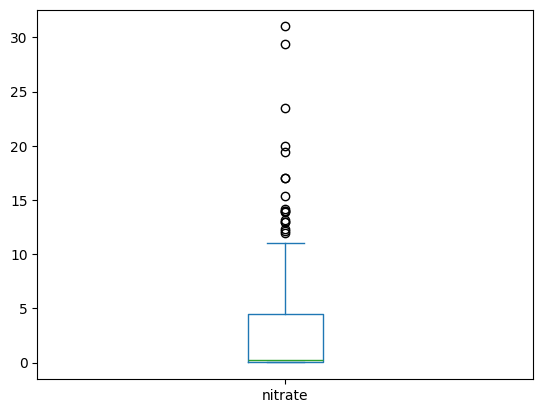

In [88]:
df[["nitrate"]].plot(kind = "box")

In [89]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-5:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

235

## Test / train split

In [90]:
n = len(df)
train_size = int(n * 0.8)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 188
Test: 47


In [91]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [92]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [93]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['soil region', 'mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['soil region', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [94]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [95]:
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=100,
    learning_rate=0.1,
    random_state=4
)

In [96]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("ada", ada_reg)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [97]:
param_dist = {
    "regressor__ada__n_estimators": [50, 100, 150],
    "regressor__ada__learning_rate": [0.01, 0.1, 0.5],
    "regressor__ada__estimator__max_depth": [2, 4, 6]
}

## Hyperparameter tuning

In [98]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False), #"r2"
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=60. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [99]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 1.1883222727198572
Best params: {'regressor__ada__n_estimators': 50, 'regressor__ada__learning_rate': 0.5, 'regressor__ada__estimator__max_depth': 4}


## Learning curve

In [100]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [101]:
n = len(X_train)

train_errors = []
val_errors = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=7)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))

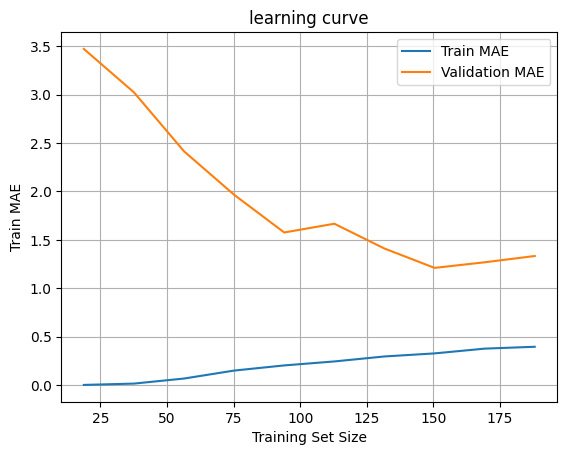

In [102]:
plt.plot(train_sizes * len(X_train), train_errors, label="Train MAE")
plt.plot(train_sizes * len(X_train), val_errors, label="Validation MAE")
plt.xlabel("Training Set Size")
plt.ylabel("Train MAE")
plt.title("learning curve")
plt.legend()
plt.grid(True)
plt.show()

## Train model

In [103]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('ada',
                                                      AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4),
                                                                        learning_rate=0.5,
                                                                        random_state=4))]))

## Final Train score

In [104]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9105138139333718
Train MAE: 0.6792864787164447
Test RMSE: 1.2473757632323113


## Final Test score

In [105]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test, pred_nitrate))
print("Test MAE:",mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.23181109933815292
Test MAE: 0.6792864787164447
Test RMSE: 1.6854479301581842


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

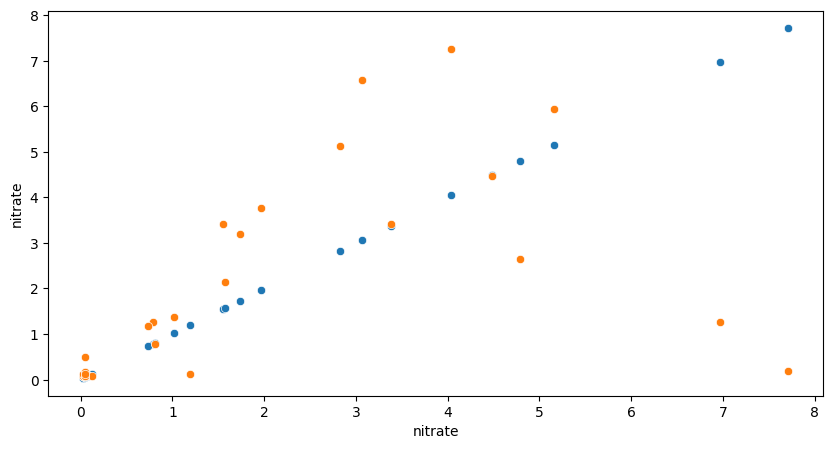

In [106]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

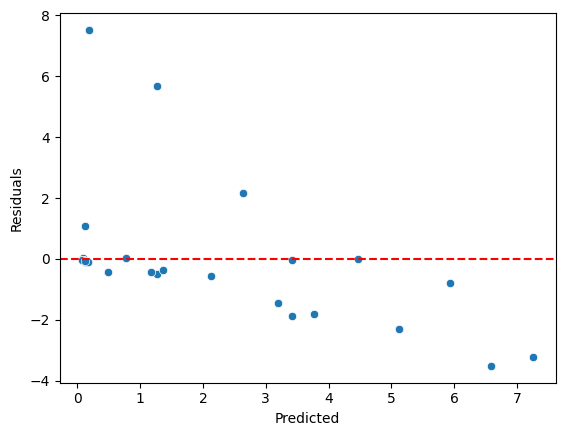

In [107]:
preds = best_model.predict(X_test)

residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [108]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

47
47
47
47


In [109]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

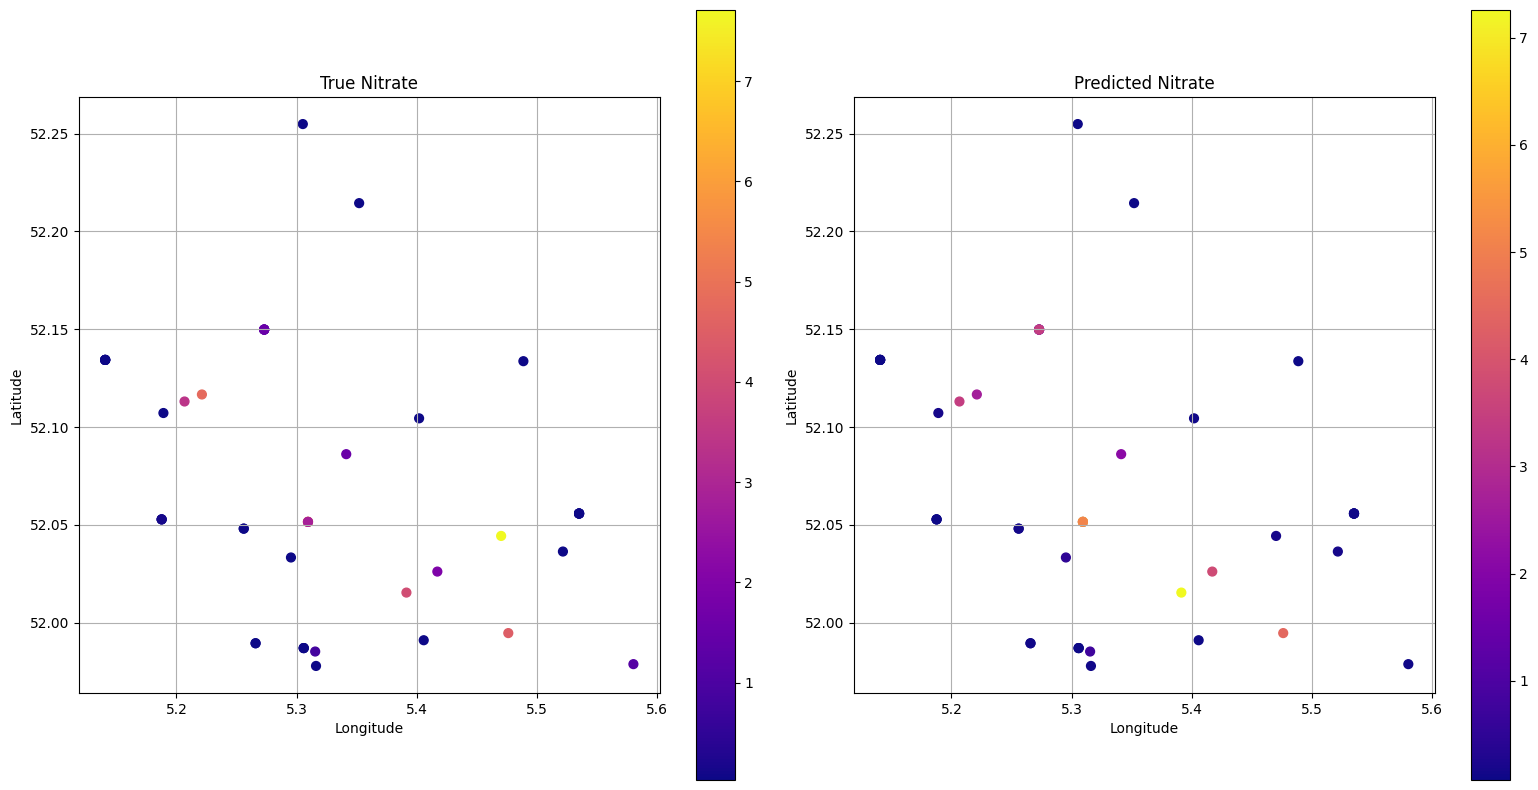

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

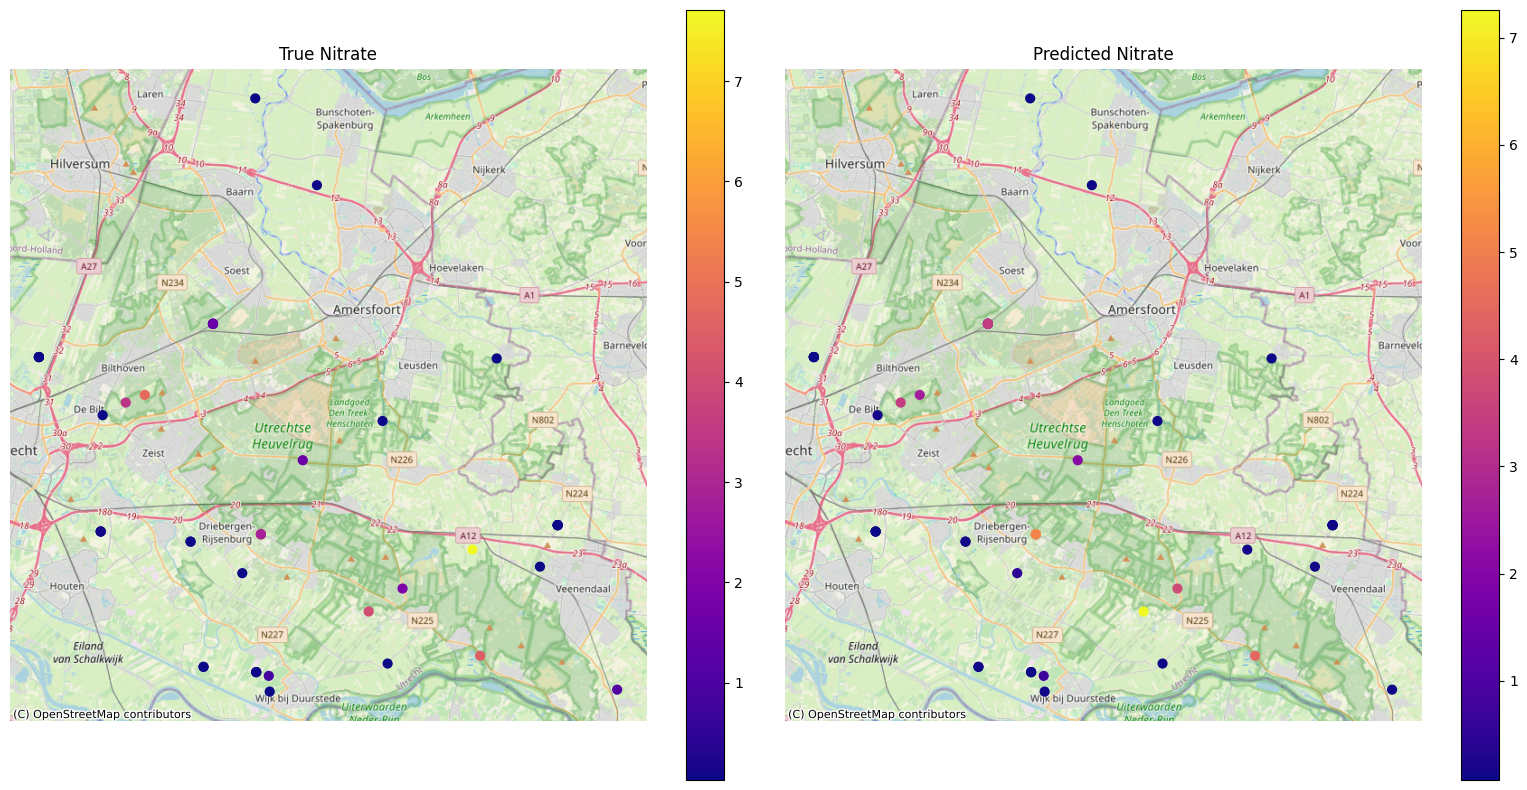

In [111]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Interpretability

In [112]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('ada',
                                                      AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4),
                                                                        learning_rate=0.5,
                                                                        random_state=4))]))

In [113]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [114]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['ada']

feature_names = fitted_preprocessor.get_feature_names_out()

### Default interpretability: Gain

In [115]:
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature  importance
18                              num_scaler__acidity_1    0.291497
11                      num_scaler__groundwater depth    0.215004
12                              num_scaler__elevation    0.128830
10                             num_scaler__population    0.121714
15                           num_scaler__n deposition    0.065090
17                              num_scaler__density_1    0.041006
16                 num_scaler__organicmattercontent_1    0.031021
3   cat_ohe__mainsoilclassification_1_Dikke eerdgr...    0.028081
14                            num_scaler__temperature    0.027518
13                          num_scaler__precipitation    0.023545
6     cat_ohe__mainsoilclassification_1_Podzolgronden    0.019471
0                           cat_ohe__soil region_klei    0.006285
5   cat_ohe__mainsoilclassification_1_Moerige gronden    0.000497
4   cat_ohe__mainsoilclassification_1_Kalkloze zan...    0.000384
2         

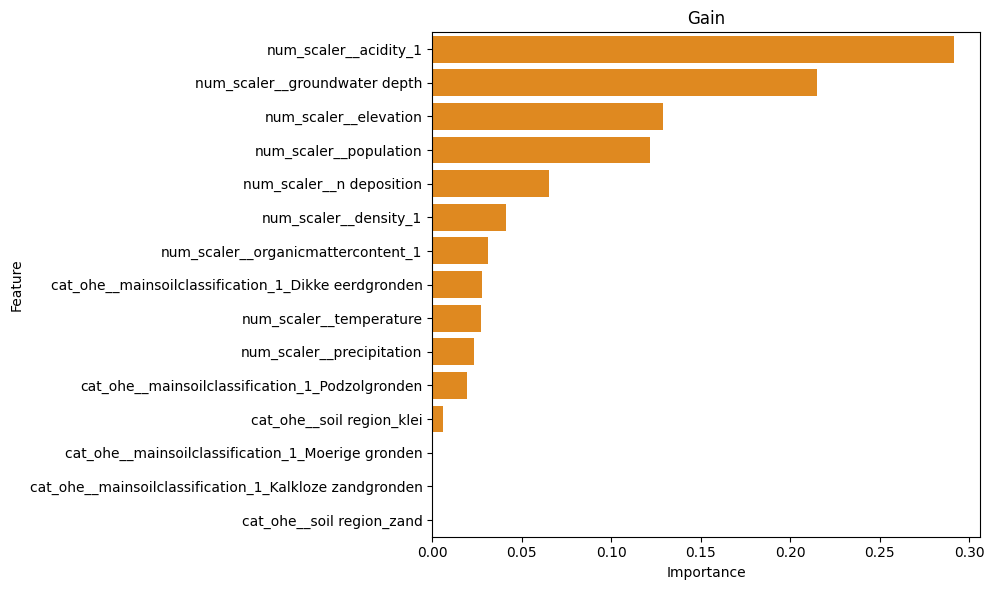

In [116]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [117]:
booster = fitted_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
# importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

AttributeError: 'AdaBoostRegressor' object has no attribute 'get_booster'

In [198]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

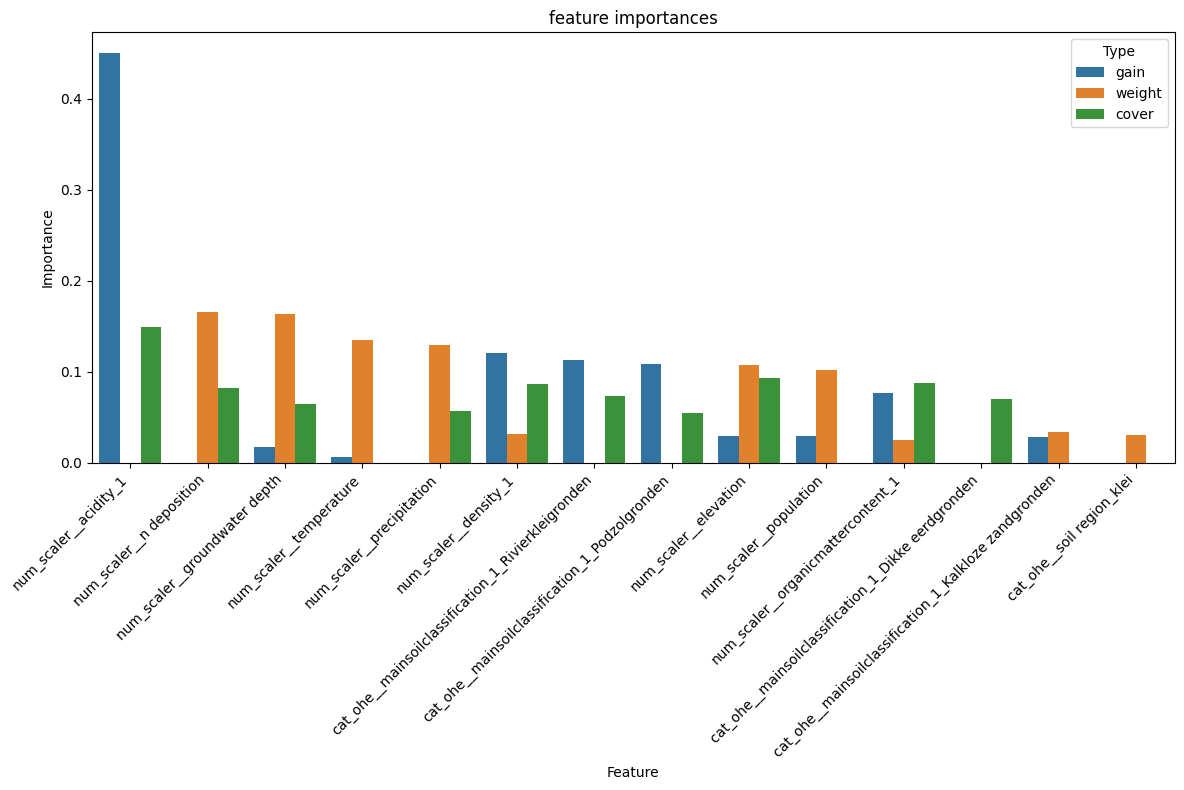

In [199]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [200]:
assert fitted_model.n_features_in_ == len(feature_names)

In [201]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

## Permutation

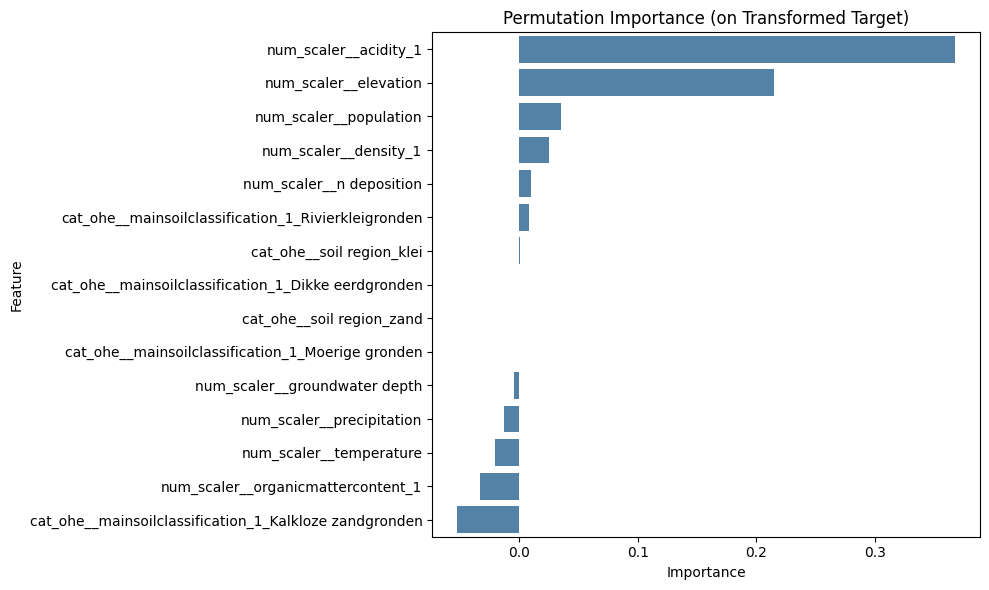

In [202]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


In [203]:
perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"

combined_df = pd.concat([importances_df, perm_df], axis=0)

In [204]:
combined_df

,Feature,Importance,Type,Std
0,cat_ohe__soil region_klei,0.005304,gain,NaN
1,cat_ohe__soil region_zand,0.000443,gain,NaN
2,cat_ohe__mainsoilclassification_1_Dikke eerdgr...,0.004913,gain,NaN
3,cat_ohe__mainsoilclassification_1_Kalkloze zan...,0.028474,gain,NaN
4,cat_ohe__mainsoilclassification_1_Moerige gronden,0.000579,gain,NaN
...,...,...,...,...
10,num_scaler__precipitation,-0.029115,permutation,0.014536
11,num_scaler__temperature,-0.046882,permutation,0.018076
13,num_scaler__organicmattercontent_1,-0.074961,permutation,0.016787
3,cat_ohe__mainsoilclassification_1_Kalkloze zan...,-0.118993,permutation,0.033319


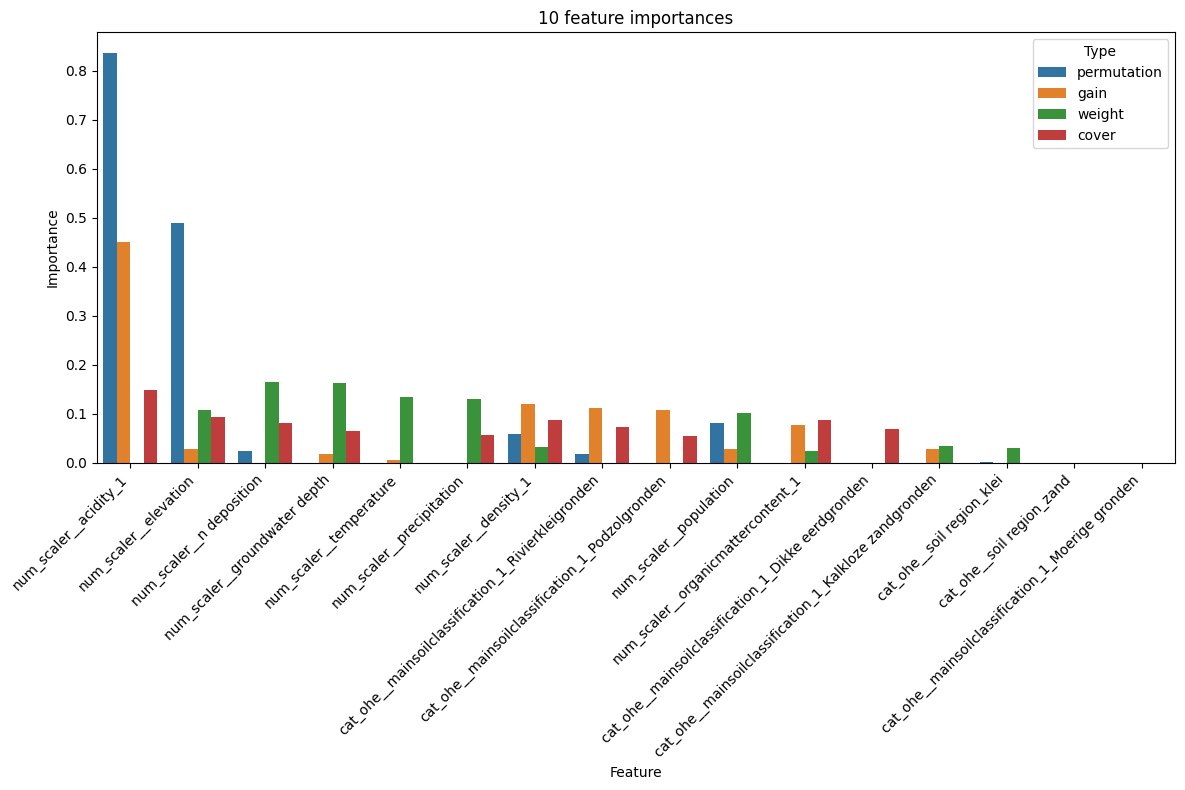

In [205]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

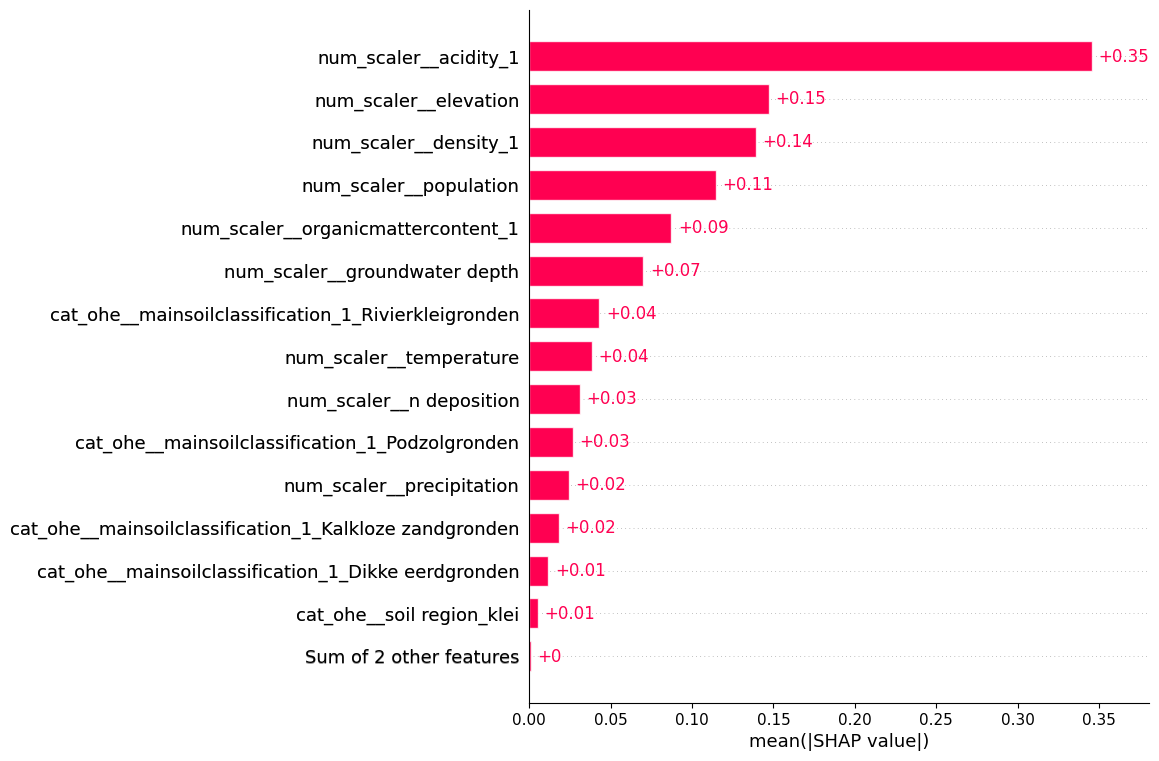

In [206]:
X_test_transformed = fitted_preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(fitted_model)

shap_values = explainer(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)


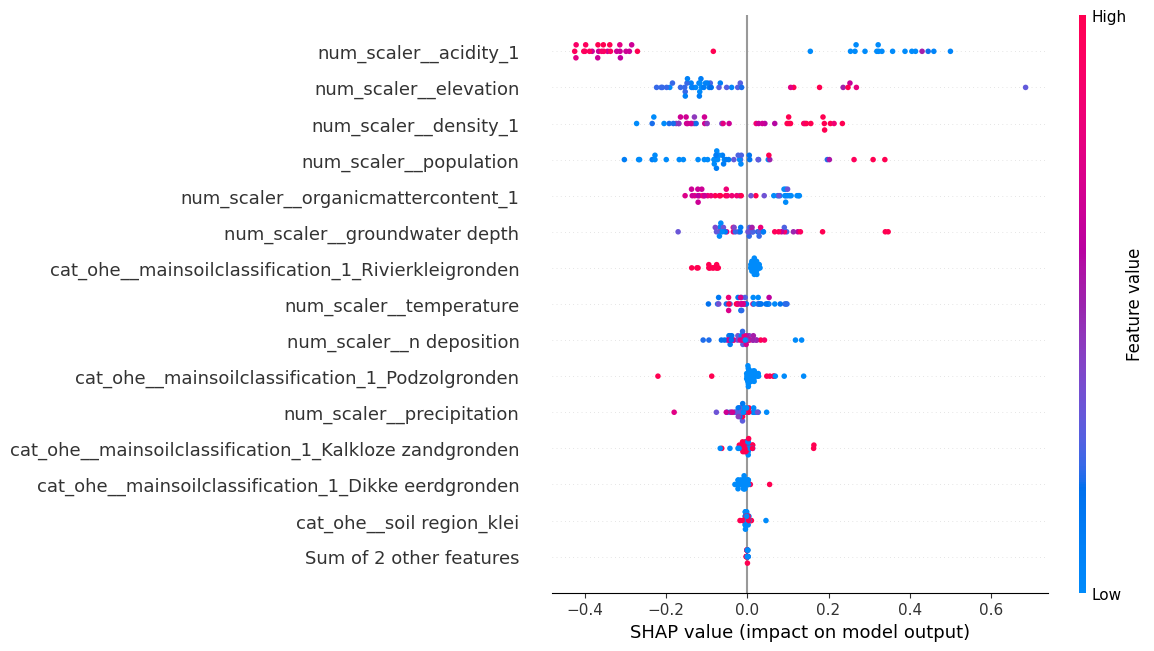

In [207]:
shap.plots.beeswarm(shap_explanation, max_display=15)